In [20]:
# Run this cell to import modules for the notebook.

### Imports ###
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
# Loading in the data.
RAW_CMS2020_DF = pd.read_csv('CMS2020.csv')

/var/folders/46/vx3njgs97gvfp07b3lv4l9rc0000gn/T/ipykernel_46003/3109432563.py:2: DtypeWarning: Columns (14,21,22,23,24,43,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types. Specify dtype option on import or set low_memory=False.
  RAW_CMS2020_DF = pd.read_csv('CMS2020.csv')


**The following filters have been applied to the RAW_CMS2020_DF dataset:**
>"nature_of_payment_or_transfer_of_value" **CONTAINS** "Compensation for services other than consulting,"
>
>"covered_recipient_type" **IS** "Covered Recipient Physician"
>
>"recipient_country" **IS** "United States"

In [148]:
# Because of the filtering of the dataset, many columns do not have any 
# information in them and are worthless to the analysis.
pd.options.mode.chained_assignment = None

CMS2020_DF = RAW_CMS2020_DF.dropna(how='all', axis=1)
CMS2020_DF.drop(CMS2020_DF.filter(regex='2').columns, axis=1, inplace=True)
CMS2020_DF.drop(CMS2020_DF.filter(regex='3').columns, axis=1, inplace=True)
CMS2020_DF.drop(CMS2020_DF.filter(regex='4').columns, axis=1, inplace=True)
CMS2020_DF.drop(CMS2020_DF.filter(regex='5').columns, axis=1, inplace=True)
print(f'The raw data contains {len(RAW_CMS2020_DF.columns)} columns and the pruned data contains {len(CMS2020_DF.columns)} columns')
CMS2020_DF.head()


The raw data contains 75 columns and the pruned data contains 42 columns


,change_type,covered_recipient_type,physician_profile_id,physician_first_name,physician_middle_name,physician_last_name,physician_name_suffix,recipient_primary_business_street_address_line1,recipient_city,recipient_state,...,record_id,dispute_status_for_publication,related_product_indicator,covered_or_noncovered_indicator_1,indicate_drug_or_biological_or_device_or_medical_supply_1,product_category_or_therapeutic_area_1,name_of_drug_or_biological_or_device_or_medical_supply_1,associated_drug_or_biological_ndc_1,program_year,payment_publication_date
0,UNCHANGED,Covered Recipient Physician,147895,DANIEL,NaN,ARNDT,NaN,3535 W 13 MILE RD STE 302,ROYAL OAK,MI,...,711979435,No,Yes,Covered,Device,Cardiology/Vascular Diseases,VNS Therapy,NaN,2020,01/21/2022
1,UNCHANGED,Covered Recipient Physician,271378,AHMED,TAWFIK,ABDELMOITY,NaN,2401 GILLHAM RD,KANSAS CITY,MO,...,711979437,No,Yes,Covered,Device,Cardiology/Vascular Diseases,VNS Therapy,NaN,2020,01/21/2022
2,UNCHANGED,Covered Recipient Physician,271378,AHMED,TAWFIK,ABDELMOITY,NaN,2401 GILLHAM RD,KANSAS CITY,MO,...,711979439,No,Yes,Covered,Device,Cardiology/Vascular Diseases,VNS Therapy,NaN,2020,01/21/2022
3,UNCHANGED,Covered Recipient Physician,258738,SELIM,R.,BENBADIS,NaN,2 TAMPA GENERAL CIR,TAMPA,FL,...,711979489,No,Yes,Covered,Device,Cardiology/Vascular Diseases,VNS Therapy,NaN,2020,01/21/2022
4,UNCHANGED,Covered Recipient Physician,271378,AHMED,TAWFIK,ABDELMOITY,NaN,2401 GILLHAM RD,KANSAS CITY,MO,...,711979497,No,Yes,Covered,Device,Cardiology/Vascular Diseases,VNS Therapy,NaN,2020,01/21/2022


**It is important to consider what data we are actually examining currently.**

The dataset is the CMS Open Payments General Payments 2020 database. It has been filtered to include:

>**ONLY** *Covered Recipient Physicians*

>**ONLY** *from the United States (including PR)*

>**ONLY** *Payment Natures of the Type: Compensation for non-consulting services (e.g., faculty/speaker at an event other than a continuing education program)*

>**The dataframe contains ONLY** *columns deemed relevant to the analysis. For example, associated_drug_or_biological_ndc_4 is not in a vast majority of these cases and most likely contains secondary information*

`One more caveat of the data is that data from different years and even from the year 2020 have slight variations in the wording from the CMS definition but they are almost identical.`

In short, all physicians in this dataset have received compensation before of this nature. Although this category is not terribly specific, the [CMS Website](https://www.cms.gov/OpenPayments/Natures-of-Payment) on "Natures of Payment" states the definition of the specified nature above *(Compensation for non-consulting services (e.g., faculty/speaker at an event other than a continuing education program)*: **Includes payments that a company makes to physicians for speaking, training, and education engagements that are not for continuing education.** With this information I am looking to find out the most contracted physician speakers of each state according to the open payments database and find some interesting facts about them. For example: 

>What do they speak about and why is it important?

>What companies or entities are contracting these speakers?

>What states have the most contracted speakers?

>How substantial is the compensation for being such frequent guest speakers?

>Who is 2020's American Physician Idol?

Beyond these questions I am also hoping to find interesting values in the data once organized that could propel new questions I had not though of before.

In [503]:
# Basic statisical details about the overall data.
total_payments = len(CMS2020_DF)
total_value = CMS2020_DF.total_amount_of_payment_usdollars.sum()
total_mean = round(np.mean(CMS2020_DF.total_amount_of_payment_usdollars), 2)
total_median = round(np.median(CMS2020_DF.total_amount_of_payment_usdollars), 2)
total_std = round(np.std(CMS2020_DF.total_amount_of_payment_usdollars), 2)
total_min = np.min(CMS2020_DF.total_amount_of_payment_usdollars)
total_max = np.max(CMS2020_DF.total_amount_of_payment_usdollars)

print(f'There are {total_payments} individual payments to physicians with a total valuation of ${total_value} for non-consulting services in the Open Payments 2020 dataset.')
print(f'The average value for this service is ~ ${total_mean}')
print(f'The median value for this service is ~ ${total_median}')
print(f'The standard deviation for this service is ${total_std}')
print(f'The smallest value for this service is ${total_min}')
print(f'The largest value for this service is ${total_max}')

There are 168956 individual payments to physicians with a total valuation of $304663998.09 for non-consulting services in the Open Payments 2020 dataset.
The average value for this service is ~ $1803.22
The median value for this service is ~ $1200.0
The standard deviation for this service is $15604.04
The smallest value for this service is $0.06
The largest value for this service is $5788500.0


In [122]:
def full_name(physician_profile_id: int):
    '''Return the physicians full name given their profile id.'''

    # Gather the parts to a physicians name.
    query = CMS2020_DF.query(f'physician_profile_id == @physician_profile_id')
    
    first = query.physician_first_name.values[0]
    middle = query.physician_middle_name.values[0]
    last = query.physician_last_name.values[0]

    # Filter out any parts of the name that are considered NaN.
    part_lst = [first, middle, last]
    name_parts = [part for part in part_lst if isinstance(part, str)]

    # Join the parts together.
    name = ' '.join(name_parts).upper()

    return name

In [500]:
# To find the next Physician Idol we need to find the physician from each state that has the most payments

# Initial dataframe creation.
state_lst = sorted(CMS2020_DF.recipient_state.unique())
state_champs_df = pd.DataFrame({
    'state': [],
    'name': [],
    'physician_profile_id': [],
    'physician_specialty': [],
    'appearances': [],
    'total_value': [],
    'value_mean': [],
    'value_median': [],
    'value_min': [],
    'value_max': [],
    'value_std': [],
    'top_contractor': [],
    'top_product_cat': [],
    'top_product_name': []
})

# For loop to find the top physician from each state.
for state in state_lst:
    # Get the dataframe of the data just for that state.
    state_df = CMS2020_DF.query('recipient_state == @state')

    # Get the id of the physician with the most payments in the state and get their dataframe.
    top_physician_id = state_df.physician_profile_id.mode()[0]
    top_physician_df = state_df.query('physician_profile_id == @top_physician_id')

    # How many entries this physician has, their specialty and their full name.
    appearances = len(top_physician_df)
    physician_specialty = top_physician_df.physician_specialty.values[0]
    name = full_name(top_physician_id)

    # The total valuation of the physician's services and related metrics.
    total_service_value = round(top_physician_df.total_amount_of_payment_usdollars.sum(), 2)
    service_value_mean = round(np.mean(top_physician_df.total_amount_of_payment_usdollars), 2)
    service_value_median = round(np.median(top_physician_df.total_amount_of_payment_usdollars), 2)
    service_value_min = np.min(top_physician_df.total_amount_of_payment_usdollars)
    service_value_max = np.max(top_physician_df.total_amount_of_payment_usdollars)
    service_value_std = np.std(top_physician_df.total_amount_of_payment_usdollars)

    # Top categorical data.
    top_manufacturer_gpo = top_physician_df.submitting_applicable_manufacturer_or_applicable_gpo_name.mode()[0]
    try:
        top_product_category = top_physician_df.indicate_drug_or_biological_or_device_or_medical_supply_1.value_counts().index[0]
    except IndexError:
        top_product_cateogory = 'None'
    try:
        top_product_name = top_physician_df.name_of_drug_or_biological_or_device_or_medical_supply_1.value_counts().index[0]
    except IndexError:
        top_product_name = 'None'

    # Create the entry to append to the data frame of state champs.
    physician_entry = {
        'state': [state],
        'name': [name],
        'physician_profile_id': [top_physician_id],
        'physician_specialty': [physician_specialty],
        'appearances': [appearances],
        'total_value': [total_service_value],
        'value_mean': [service_value_mean],
        'value_median': [service_value_median],
        'value_min': [service_value_min],
        'value_max': [service_value_max],
        'value_std': [service_value_std],
        'top_contractor': [top_manufacturer_gpo],
        'top_product_cat': [top_product_category],
        'top_product_name': [top_product_name]
    }

    physician_entry_df = pd.DataFrame(physician_entry)
    state_champs_df = pd.concat([state_champs_df, physician_entry_df], ignore_index=True)

state_champs_df.physician_profile_id = state_champs_df.physician_profile_id.astype(int)
state_champs_df.appearances = state_champs_df.appearances.astype(int)
state_champs_df.sort_values('appearances', inplace=True, ascending=False)
state_champs_df.reset_index(inplace=True)
state_champs_df.drop(columns=['index'], inplace=True)
state_champs_df.head(30)

,state,name,physician_profile_id,physician_specialty,appearances,total_value,value_mean,value_median,value_min,value_max,value_std,top_contractor,top_product_cat,top_product_name
0,TX,RAKESH JAIN,232968,Allopathic & Osteopathic Physicians|Psychiatry...,266,438986.00,1650.32,1265.0,205.00,4485.00,1052.291800,Eisai Inc.,Drug,Dayvigo
1,CA,ANDREW MICHAEL BLUMENFELD,324864,Allopathic & Osteopathic Physicians|Psychiatry...,256,471932.50,1843.49,1580.0,200.00,8970.00,1369.230930,"Allergan, Inc.",Drug,UBRELVY
2,IN,ISAIAH PITTMAN,298650,Allopathic & Osteopathic Physicians|Internal M...,237,255795.40,1079.31,650.0,200.00,3700.00,808.805300,Eli Lilly and Company,Drug,TRULICITY
3,MI,MICHAEL VALITUTTO,331637,Allopathic & Osteopathic Physicians|Internal M...,220,179716.50,816.89,650.0,200.00,3700.00,517.957092,Eli Lilly and Company,Drug,TRULICITY
4,NY,ROBERT BUSCH,293095,Allopathic & Osteopathic Physicians|Internal M...,219,247858.50,1131.77,800.0,200.00,5625.00,767.878183,Eli Lilly and Company,Drug,TRULICITY
5,GA,DAVID GEREALD ROBERTSON,347772,Allopathic & Osteopathic Physicians|Internal M...,193,257789.00,1335.69,800.0,200.00,4300.00,992.691090,Eli Lilly and Company,Drug,TRULICITY
6,TN,CRAIG WIERUM,380490,Allopathic & Osteopathic Physicians|Internal M...,191,202622.00,1060.85,800.0,200.00,3485.00,620.002755,Eli Lilly and Company,Drug,TRULICITY
7,OR,EDEN M MILLER,141274,Allopathic & Osteopathic Physicians|Family Med...,186,158860.75,854.09,650.0,162.50,9452.25,825.831797,Eli Lilly and Company,Drug,TRULICITY
8,OK,JACLYN DUVALL,125175,Allopathic & Osteopathic Physicians|Psychiatry...,180,176295.00,979.42,700.0,200.00,3570.00,694.015945,Eli Lilly and Company,Drug,REYVOW
9,OH,ELENA A. CHRISTOFIDES,58640,Allopathic & Osteopathic Physicians|Internal M...,177,258363.50,1459.68,1050.0,200.00,6300.00,925.386205,Eli Lilly and Company,Drug,TRULICITY


In [ ]:
# Use an extra module to create and save a table image.
import dataframe_image as dfi
styled_state_champs = state_champs_df.style.background_gradient()
dfi.export(styled_state_champs, 'STATE_CHAMPS.png')

In [308]:
# Some interesting data points.

highest_gross = np.max(state_champs_df.total_value.values)
print(highest_gross)

497660.0


# Where does the money come from?

In [397]:
# Fonts
label_font = {
        'family': 'Lato',
        'weight': 'bold',
        'size': 14
        }
title_font = {
        'family': 'Lato',
        'weight': 'bold',
        'size': 20
        }
bar_font = {
        'family': 'monospace',
        'weight': 'bold',
        'stretch': 'expanded',
        'color': 'w',
        'size': 12
    }

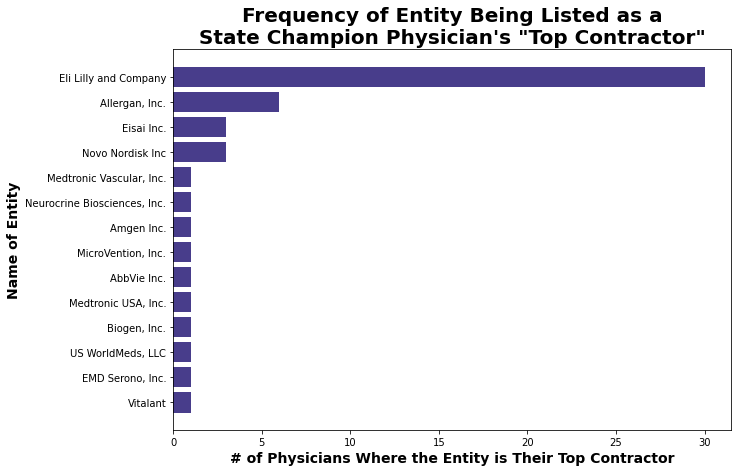

In [497]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.invert_yaxis()

plt.title('Frequency of Entity Being Listed as a\nState Champion Physician\'s "Top Contractor"', fontdict=title_font)
plt.xlabel('# of Physicians Where the Entity is Their Top Contractor', fontdict=label_font)
plt.ylabel('Name of Entity', fontdict=label_font)

entities_ax_x = state_champs_df.top_contractor.value_counts()
entities_ax_y = state_champs_df.top_contractor.value_counts().index

top_entities_hbar = plt.barh(entities_ax_y, entities_ax_x, facecolor='darkslateblue')
top_contracting_entities_bar_labels = state_champs_df.top_contractor.value_counts().values
plt.savefig("TOP_CONTRACTING_ENTITIES.png", dpi=300, bbox_inches = 'tight')


**Much of the money for these physicians is coming from Eli Lilly and Company**

In [382]:
# Money spent by Eli Lilly and Company.

eli_lilly_df = CMS2020_DF[CMS2020_DF.submitting_applicable_manufacturer_or_applicable_gpo_name == 'Eli Lilly and Company']
total_payments = len(eli_lilly_df.total_amount_of_payment_usdollars)
payment_sum = round(eli_lilly_df.total_amount_of_payment_usdollars.sum(), 2)

print(f'Eli and Lilly Company made {total_payments} payments summing up to a valuation of ${payment_sum}')

el_mean_payments = round(np.mean(eli_lilly_df.total_amount_of_payment_usdollars.values), 2)
el_median_payments = round(np.median(eli_lilly_df.total_amount_of_payment_usdollars.values), 2)
el_std_dev_payments = round(np.std(eli_lilly_df.total_amount_of_payment_usdollars.values), 2)

print(f'The mean and median of these payments is ${el_mean_payments} and ${el_median_payments} respectively with a standard deviation of ${el_std_dev_payments}.')

Eli and Lilly Company made 19993 payments summing up to a valuation of $20652703.04
The mean and median of these payments is $1033.0 and $800.0 respectively with a standard deviation of $1481.04.


In [502]:
# Money spent by MicroVention, Inc.

mv_df = CMS2020_DF[CMS2020_DF.submitting_applicable_manufacturer_or_applicable_gpo_name == 'MicroVention, Inc.']

mv_max_payment = np.max(mv_df.total_amount_of_payment_usdollars.values)
is_max_payment = mv_df['total_amount_of_payment_usdollars'] == mv_max_payment
mv_max_payment_df = mv_df[is_max_payment]
mv_max_payment_df.dropna(axis=1)

phys_id = mv_max_payment_df.physician_profile_id.values[0]
phys_name = full_name(phys_id)

print(f'The physician, {phys_name} holds the largest single payment of all the state champs with a value {mv_max_payment}')

is_without_mv = state_champs_df['value_max'] != mv_max_payment
without_mv_max_df = state_champs_df[is_without_mv]
champs_without_mv_max_mean = round(np.mean(without_mv_max_df.value_max), 2)
champs_without_mv_max_median = round(np.median(without_mv_max_df.value_max), 2)
champs_without_mv_max_std = round(np.std(without_mv_max_df.value_max), 2)
print(f'The mean and median of the max single payment other State Champ Physicians received is ${champs_without_mv_max_mean} and ${champs_without_mv_max_median} respectively with a standard deviation of ${champs_without_mv_max_std}')
mv_max_payment_df

The physician, JOSSER E. DELGADO holds the largest single payment of all the state champs with a value 30500.0
The mean and median of the max single payment other State Champ Physicians received is $5310.78 and $4420.0 respectively with a standard deviation of $3299.41


,change_type,covered_recipient_type,physician_profile_id,physician_first_name,physician_middle_name,physician_last_name,physician_name_suffix,recipient_primary_business_street_address_line1,recipient_city,recipient_state,...,record_id,dispute_status_for_publication,related_product_indicator,covered_or_noncovered_indicator_1,indicate_drug_or_biological_or_device_or_medical_supply_1,product_category_or_therapeutic_area_1,name_of_drug_or_biological_or_device_or_medical_supply_1,associated_drug_or_biological_ndc_1,program_year,payment_publication_date
144573,UNCHANGED,Covered Recipient Physician,315094,JOSSER,NaN,DELGADO,NaN,7505 METRO BLVD STE 400,MINNEAPOLIS,MN,...,751816801,No,Yes,Covered,Device,Neurological Product,WEB,NaN,2020,01/21/2022


# Where does the money go?

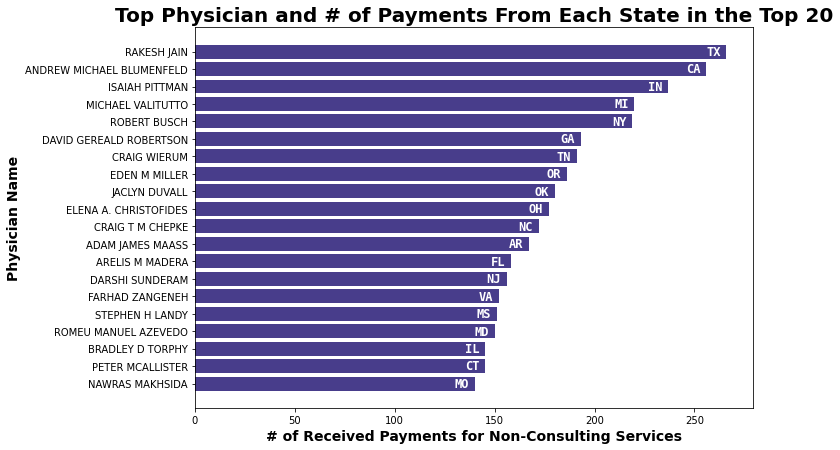

In [457]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.invert_yaxis()
ax_y = state_champs_df.name.values[:20]
ax_x = state_champs_df.appearances.values[:20]
top_phys_bar_labels = state_champs_df.state.values[:20]

plt.title('Top Physician and # of Payments From Each State in the Top 20', fontdict=title_font)
plt.xlabel('# of Received Payments for Non-Consulting Services', fontdict=label_font)
plt.ylabel('Physician Name', fontdict=label_font)

hbar_plot = plt.barh(ax_y, ax_x, facecolor='darkslateblue')

def barh_autolabel(bars: plt, bar_labels: list = top_phys_bar_labels, width_adjust: float = 10.0, height_adjust: float = 0.75):
    '''A function for labeling the end of each bar with the state the physician is from.'''

    for count, bar in enumerate(bars):
        width = bar.get_width()
        height = bar.get_height()
        x_pos = width - width_adjust
        y_pos = bar.get_y() + height * height_adjust
        
        state_text = bar_labels[count]

        plt.text(x_pos, y_pos, state_text, fontdict=bar_font)

barh_autolabel(hbar_plot)
plt.savefig("TOP_PHYSICIANS_BY_STATE.png", dpi=300, bbox_inches = 'tight')

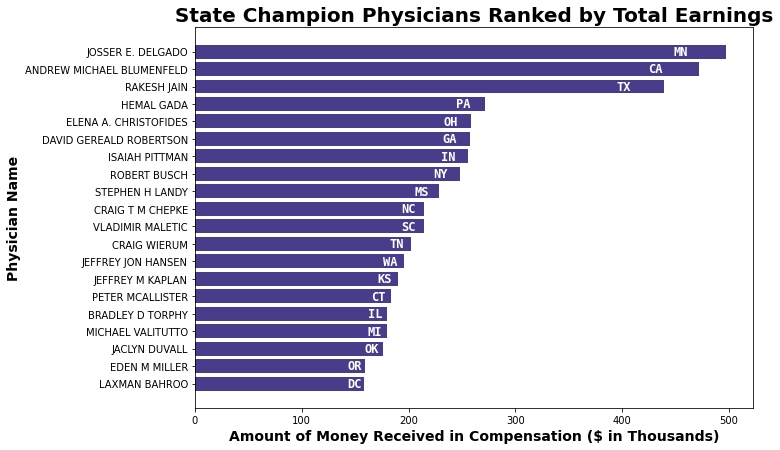

In [496]:
plt.close()

scp_money_df = state_champs_df.sort_values('total_value')

fig, ax = plt.subplots(figsize=(10, 7))
ax_y = scp_money_df.name.values[32:]
ax_x = [(int(val) / 1000) for val in scp_money_df.total_value.values[32:]]
top_phys_val_bar_labels = scp_money_df.state.values[32:]

plt.title('State Champion Physicians Ranked by Total Earnings', fontdict=title_font)
plt.xlabel('Amount of Money Received in Compensation ($ in Thousands)', fontdict=label_font)
plt.ylabel('Physician Name', fontdict=label_font)

hbar_plot = plt.barh(ax_y, ax_x, facecolor='darkslateblue')

def bar_labeler(bars: plt):
    '''Labels the figure of this cell.'''

    for count, bar in enumerate(bars):
        val_width = bar.get_width()
        val_height = bar.get_height()
        val_x_pos = val_width * 0.9
        val_y_pos = bar.get_y() + val_height * 0.25
        
        state_text = top_phys_val_bar_labels[count]

        plt.text(val_x_pos, val_y_pos, state_text, fontdict=bar_font)

bar_labeler(hbar_plot)


#plt.savefig("TOP PHYSICIANS BY EARNINGS.png", dpi=300, bbox_inches='tight')

In [498]:
scp_mean_payment = round(np.mean(state_champs_df.value_mean.values), 2)
scp_median_payment = round(np.median(state_champs_df.value_mean.values), 2)
scp_std_dev_payment = round(np.std(state_champs_df.value_mean.values), 2)

print(f'The mean and median of the SCP mean value payments are ${scp_mean_payment} and ${scp_median_payment} respectively with a standard deviation of ${scp_std_dev_payment}')ay

The mean and median of the SCP mean value payments are $1425.16 and $1314.52 respectively with a standard deviation of $689.45


# How does the data change?